#**Machine Learning Prediction of company’s success or bankruptcy**

### **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

**Load Dataset**

In [2]:
# Load the dataset
df = pd.read_csv('data_rename.csv')


In [3]:
## Display first few rows of the data
df.head()

,bankrupt,roa_c,roa_a,roa_b,op_gross_margin,realized_gross_margin,op_profit_rate,pretax_net_rate,aftertax_net_rate,nonindustry_inc_ratio,...,netincome_to_assets,assets_to_gnp,no_credit_interval,grossprofit_to_sales,netincome_to_equity,liability_to_equity,degree_financial_leverage,interest_coverage_ratio,netincome_flag,equity_to_liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [4]:
# Check initial data info
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6665 entries, 0 to 6664
Data columns (total 96 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   bankrupt                         6665 non-null   int64  
 1   roa_c                            6665 non-null   float64
 2   roa_a                            6665 non-null   float64
 3   roa_b                            6665 non-null   float64
 4   op_gross_margin                  6665 non-null   float64
 5   realized_gross_margin            6665 non-null   float64
 6    op_profit_rate                  6665 non-null   float64
 7   pretax_net_rate                  6665 non-null   float64
 8   aftertax_net_rate                6665 non-null   float64
 9   nonindustry_inc_ratio            6665 non-null   float64
 10  cont_interest_rate               6665 non-null   float64
 11  op_expense_rate                  6665 non-null   float64
 12  r_and_d_expense_rate

## **Data Preprocessing**

#### **Separate Features and Target Variable**

In [5]:
# Separate target and features
X = df.drop('bankrupt', axis=1)
y = df['bankrupt']



#### **Checking the class distribution of target variable "Bankrupt"**

bankrupt
0    6446
1     219
Name: count, dtype: int64


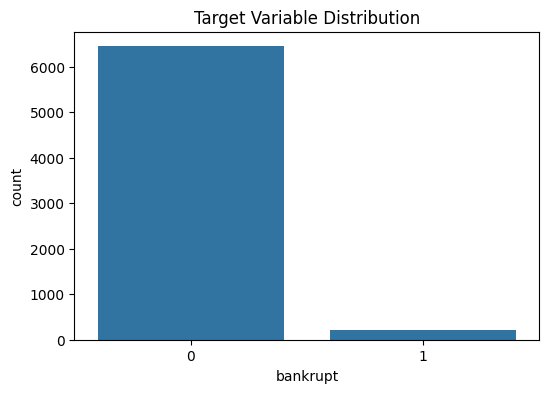

In [6]:
# Print distribution of target variable
print(y.value_counts())

# Plot Class Distribution of Target variable
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Target Variable Distribution')
plt.savefig('Target Variable Distribution.png', dpi=300)
plt.show()

#### **Handling missing values**

In [7]:
# Check for missing values
print(X.isnull().sum())


roa_c                        0
roa_a                        0
roa_b                        0
op_gross_margin              0
realized_gross_margin        0
                            ..
liability_to_equity          0
degree_financial_leverage    0
interest_coverage_ratio      0
netincome_flag               0
equity_to_liability          0
Length: 95, dtype: int64


#### **Detecting and Handling Outliers (IQR Method)¶**

In [8]:
# Handling outliers by replacing them with IQR bounds
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    X[col] = np.where(X[col] < lower_bound, lower_bound, X[col])
    X[col] = np.where(X[col] > upper_bound, upper_bound, X[col])


#### **Feature Scaling (Standardization)**

In [9]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


#### **Dropping Constant Features**

In [10]:
# Drop features that have the same value everywhere
constant_features = [col for col in X_scaled.columns if X_scaled[col].nunique() == 1]
X_scaled =X_scaled.drop(columns=constant_features)

print(f"Dropped {len(constant_features)} constant features.")


Dropped 2 constant features.


### **Dropping Highly Correlated Features**

In [11]:
# Drop one of each pair of highly correlated features
corr_matrix = X_scaled.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]
X_scaled = X_scaled.drop(columns=high_corr_features)

print(f"Dropped {len(high_corr_features)} highly correlated features.")


Dropped 41 highly correlated features.


#### **Feature Selection (Top 30 Variables)**

Selected Features: ['roa_c', 'op_gross_margin', ' op_profit_rate', 'nonindustry_inc_ratio', 'cash_flow_rate', 'debt_interest_rate', 'tax_rate_a', 'net_val_share_b', 'cash_flow_per_share', 'realized_gross_growth', 'op_profit_growth', 'aftertax_profit_growth', 'net_value_growth', 'asset_return_growth', 'current_ratio', 'interest_expense_ratio', 'debt_to_networth', 'borrowing_dependency', 'inv_and_rec_to_netval', 'op_profit_per_person', 'allocation_per_person', 'workingcap_to_assets', 'cash_to_assets', 'cash_to_liability', 'currliability_to_assets', 'longtermliability_to_currassets', 'expense_to_assets', 'workingcap_turnover', 'equity_to_longtermliability', 'no_credit_interval']


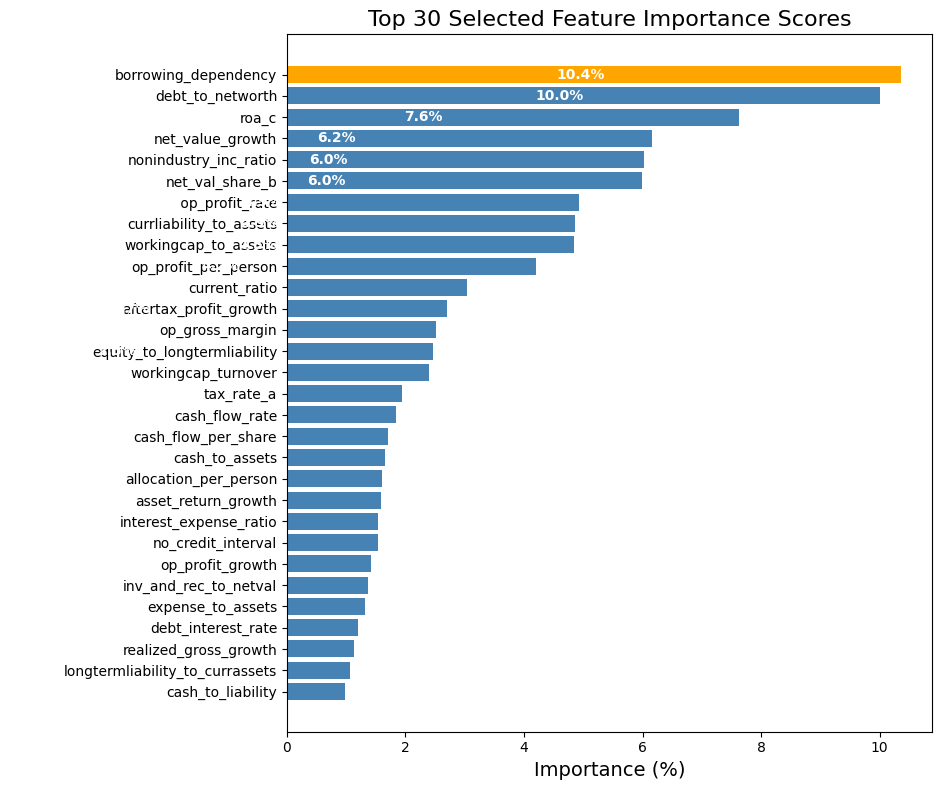

In [12]:
# Select Top 30 important features
selector = SelectKBest(score_func=f_classif, k=30)
X_selected_array = selector.fit_transform(X_scaled, y)
selected_features = X_scaled.columns[selector.get_support()]

# Convert selected features back to DataFrame
X_selected = pd.DataFrame(X_selected_array, columns=selected_features)

print('Selected Features:', list(selected_features))

# Prepare scores
scores = selector.scores_[selector.get_support()]
feature_scores = pd.Series(scores, index=selected_features).sort_values(ascending=False)

# Normalize scores to percentage
percentages = 100 * feature_scores / feature_scores.sum()

# Set colors: orange for top feature, steelblue for others
colors = ['orange' if i == 0 else 'steelblue' for i in range(len(feature_scores))]

# Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(feature_scores.index, percentages, color=colors)
plt.gca().invert_yaxis()  # Highest score on top
plt.title('Top 30 Selected Feature Importance Scores', fontsize=16)
plt.xlabel('Importance (%)', fontsize=14)

# Add percentage text inside bars
for bar, percentage in zip(bars, percentages):
    plt.text(
        bar.get_width() - 5,  # a bit inside from the right edge
        bar.get_y() + bar.get_height()/2,
        f'{percentage:.1f}%',
        ha='right', va='center', color='white', fontsize=10, fontweight='bold'
    )

# Save the plot as a PNG file
plt.tight_layout()
plt.savefig('top_30_feature_importances.png', dpi=300)

plt.show()


#### **Correlation after feature selection**

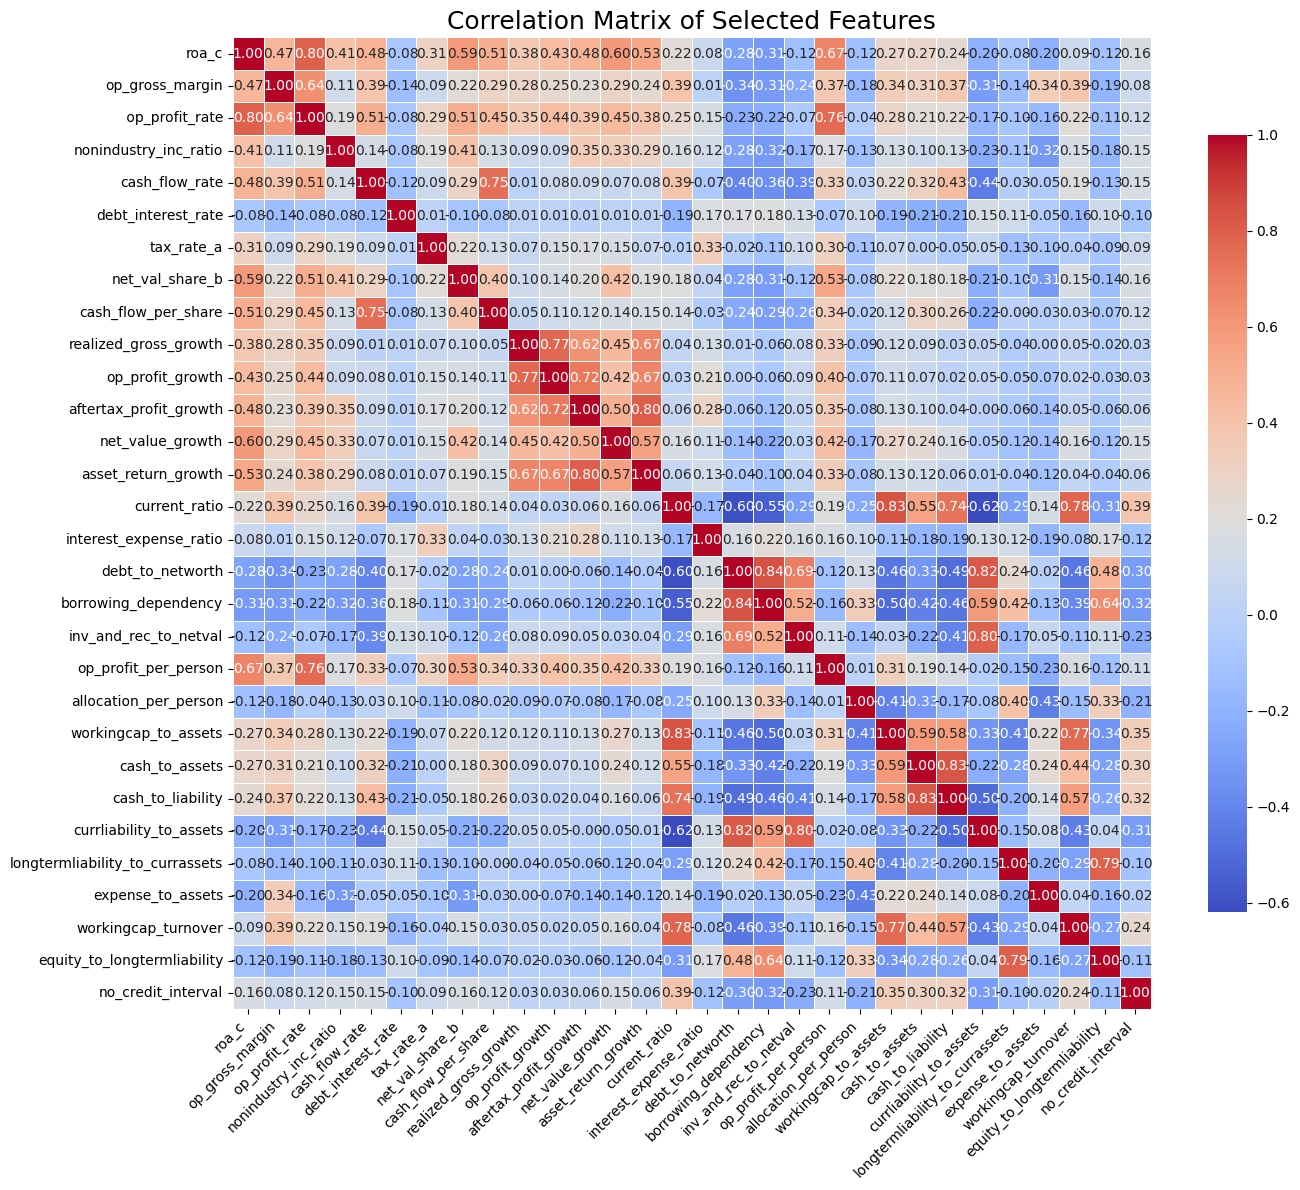

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix of selected features
plt.figure(figsize=(14, 12))
corr_matrix = X_selected.corr()

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,            # Show correlation values inside boxes
    fmt=".2f",              # Format numbers to 2 decimal places
    linewidths=0.5,         # Add lines between boxes
    cbar_kws={"shrink": 0.8} # Smaller color bar
)

plt.title('Correlation Matrix of Selected Features', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
# Save the plot as a PNG file
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)

plt.show()


**Handling Class Imbalance**

In [14]:
# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_selected, y)

# Check new class distribution
print(y_balanced.value_counts())


bankrupt
1    6446
0    6446
Name: count, dtype: int64


**Splitting Data into Training and Test Sets**

In [15]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)


**Initializing Models**

In [16]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Neural Network (MLP)': MLPClassifier(max_iter=1000)
}


**Cross-Validation and Model Comparison**

In [17]:
cv_results = {}

for model_name, model in models.items():
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_results[model_name] = cv_score.mean()

print('\nCross-Validation Results:')
for model_name, score in cv_results.items():
    print(f'{model_name} - CV Accuracy: {score:.4f}')



Cross-Validation Results:
Logistic Regression - CV Accuracy: 0.8839
Random Forest - CV Accuracy: 0.9764
XGBoost - CV Accuracy: 0.9800
Neural Network (MLP) - CV Accuracy: 0.9834


**Hyperparameter Tuning with GridSearchCV**

In [18]:
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [5, 10, 20]},
    'XGBoost': {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200]},
    'Neural Network (MLP)': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh']}
}

best_models = {}

for model_name, model in models.items():
    print(f'\nTuning hyperparameters for {model_name}...')
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f'Best parameters for {model_name}: {grid_search.best_params_}')



Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.1}

Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}

Tuning hyperparameters for XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 200}

Tuning hyperparameters for Neural Network (MLP)...
Best parameters for Neural Network (MLP): {'activation': 'relu', 'hidden_layer_sizes': (100,)}


**Model Training and Evaluation**

In [19]:
for model_name, model in best_models.items():
    print(f'\nEvaluating {model_name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


Evaluating Logistic Regression...

Evaluating Random Forest...

Evaluating XGBoost...

Evaluating Neural Network (MLP)...


In [20]:
    # Accuracy and Classification Report
    print(f'Accuracy of {model_name}: {accuracy_score(y_test, y_pred):.4f}')
    print('Classification Report:\n', classification_report(y_test, y_pred))


Accuracy of Neural Network (MLP): 0.9895
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1290
           1       0.98      1.00      0.99      1289

    accuracy                           0.99      2579
   macro avg       0.99      0.99      0.99      2579
weighted avg       0.99      0.99      0.99      2579



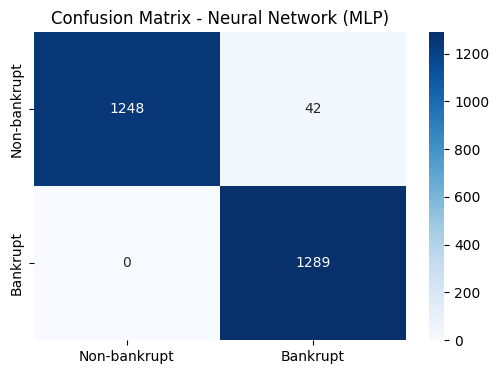

In [73]:
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-bankrupt', 'Bankrupt'], yticklabels=['Non-bankrupt', 'Bankrupt'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig('Confusion Matrix.png', dpi=300)
    plt.show()


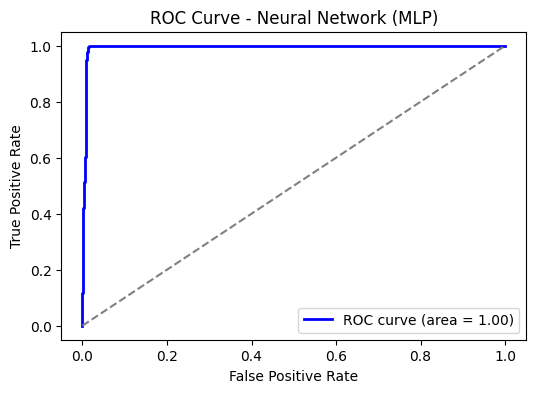

In [74]:
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.savefig('ROC Curve.png', dpi=300)
    plt.show()

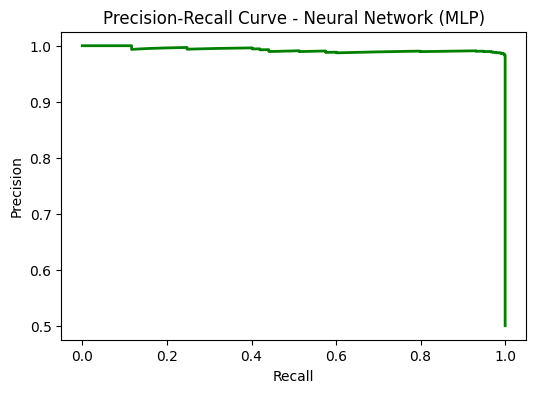

In [75]:
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.show()

**Saving result and plots**

In [24]:
import os

# Create a directory to save plots
os.makedirs('model_plots', exist_ok=True)

# Prepare a DataFrame to save evaluation metrics
results = []

for model_name, model in best_models.items():
    print(f'\nEvaluating {model_name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy of {model_name}: {acc:.4f}')

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    print('Classification Report:\n', classification_report(y_test, y_pred))





Evaluating Logistic Regression...
Accuracy of Logistic Regression: 0.8887
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89      1290
           1       0.87      0.92      0.89      1289

    accuracy                           0.89      2579
   macro avg       0.89      0.89      0.89      2579
weighted avg       0.89      0.89      0.89      2579


Evaluating Random Forest...
Accuracy of Random Forest: 0.9822
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1290
           1       0.97      1.00      0.98      1289

    accuracy                           0.98      2579
   macro avg       0.98      0.98      0.98      2579
weighted avg       0.98      0.98      0.98      2579


Evaluating XGBoost...
Accuracy of XGBoost: 0.9798
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0

In [25]:
    # Save the results into a list (for Excel)
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision (Non-bankrupt)': report['0']['precision'],
        'Recall (Non-bankrupt)': report['0']['recall'],
        'F1-Score (Non-bankrupt)': report['0']['f1-score'],
        'Precision (Bankrupt)': report['1']['precision'],
        'Recall (Bankrupt)': report['1']['recall'],
        'F1-Score (Bankrupt)': report['1']['f1-score'],
    })


In [26]:
    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-bankrupt', 'Bankrupt'], yticklabels=['Non-bankrupt', 'Bankrupt'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'model_plots/{model_name}_confusion_matrix.png')
    plt.close()

    # ROC Curve Plot
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'model_plots/{model_name}_roc_curve.png')
    plt.close()

    # Precision-Recall Curve Plot
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.savefig(f'model_plots/{model_name}_precision_recall_curve.png')
    plt.close()


In [27]:
# Save all results to Excel
results_df = pd.DataFrame(results)
results_df.to_excel('model_evaluation_results.xlsx', index=False)

print('\nEvaluation completed. Results saved to "model_evaluation_results.xlsx" and plots saved to "model_plots" folder.')


Evaluation completed. Results saved to "model_evaluation_results.xlsx" and plots saved to "model_plots" folder.


**Feature Importance Plot of Key Predictors**


Feature Importance for Logistic Regression


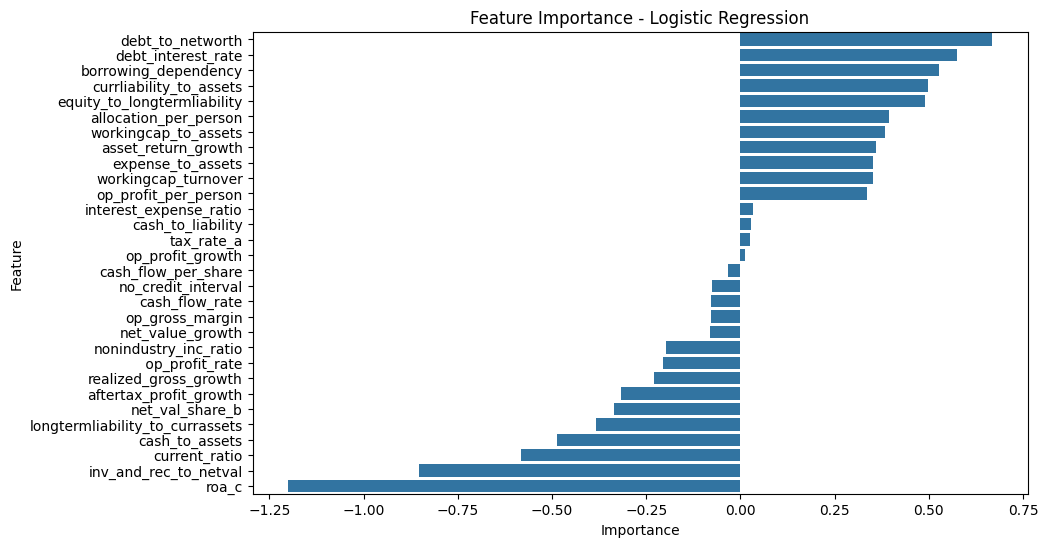


Feature Importance for Random Forest


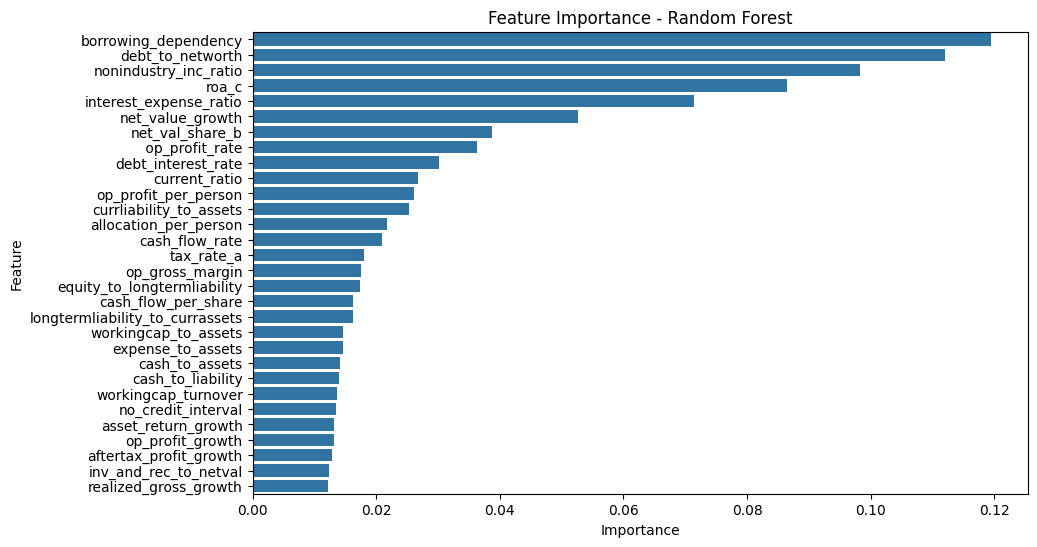


Feature Importance for XGBoost


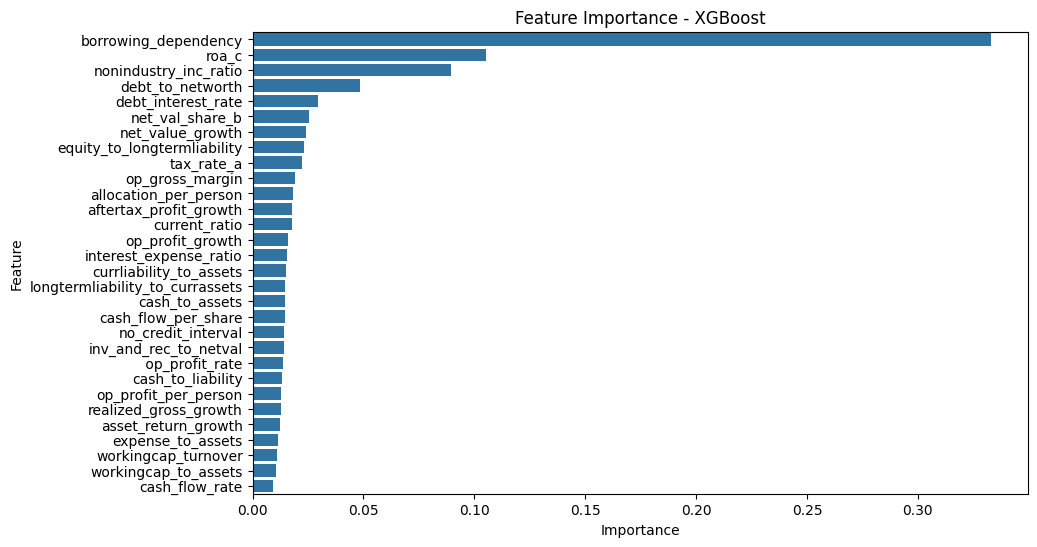


Feature Importance for Neural Network (MLP)


In [76]:
for model_name, model in best_models.items():
    print(f'\nFeature Importance for {model_name}')

    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = model.coef_[0]
    else:
        importance = None

    if importance is not None:
        importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()


**Saving plots**

In [29]:
# Make sure the directory exists
os.makedirs('feature_importance_plots', exist_ok=True)

for model_name, model in best_models.items():
    print(f'\nFeature Importance for {model_name}')

    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = model.coef_[0]
    else:
        importance = None

    plt.figure(figsize=(10, 6))

    if importance is not None:
        importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)

        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
    else:
        # Create a dummy plot
        plt.text(0.5, 0.5, 'No Feature Importance Available',
                 fontsize=14, ha='center', va='center')
        plt.title(f'Feature Importance - {model_name}')
        plt.axis('off')

    # Save the figure
    plt.tight_layout()
    plt.savefig(f'feature_importance_plots/feature_importance_{model_name}.png')
    plt.close()



Feature Importance for Logistic Regression

Feature Importance for Random Forest

Feature Importance for XGBoost

Feature Importance for Neural Network (MLP)


### **Building Predictive System**

In [30]:
!pip install gradio huggingface_hub joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00


In [31]:
# Create a project folder
os.makedirs("bankruptcy-prediction-app", exist_ok=True)

#### **Save the Model**

In [32]:
import joblib

# Correctly save each model individually
joblib.dump(best_models["Logistic Regression"], "Logistic_Regression.pkl")
joblib.dump(best_models["Random Forest"], "Random_Forest.pkl")
joblib.dump(best_models["XGBoost"], "XGBoost.pkl")
joblib.dump(best_models["Neural Network (MLP)"], "Neural_Network_(MLP).pkl")

# Save scaler and selected features
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(list(selected_features), 'selected_features.pkl')


['selected_features.pkl']

In [33]:
print("Selected features:", selected_features)
print("Number of features:", len(selected_features))


Selected features: Index(['roa_c', 'op_gross_margin', ' op_profit_rate', 'nonindustry_inc_ratio',
       'cash_flow_rate', 'debt_interest_rate', 'tax_rate_a', 'net_val_share_b',
       'cash_flow_per_share', 'realized_gross_growth', 'op_profit_growth',
       'aftertax_profit_growth', 'net_value_growth', 'asset_return_growth',
       'current_ratio', 'interest_expense_ratio', 'debt_to_networth',
       'borrowing_dependency', 'inv_and_rec_to_netval', 'op_profit_per_person',
       'allocation_per_person', 'workingcap_to_assets', 'cash_to_assets',
       'cash_to_liability', 'currliability_to_assets',
       'longtermliability_to_currassets', 'expense_to_assets',
       'workingcap_turnover', 'equity_to_longtermliability',
       'no_credit_interval'],
      dtype='object')
Number of features: 30


In [34]:
import joblib
# Load components
scaler = joblib.load('scaler.pkl')
selected_features = joblib.load('selected_features.pkl')

# Get the feature names the scaler was fitted with
scaler_feature_names = scaler.feature_names_in_ if hasattr(scaler, 'feature_names_in_') else None

# Correct feature names by checking against scaler's expected features
selected_features = [feature.strip() for feature in selected_features]  # Remove leading/trailing spaces
if scaler_feature_names is not None:
    # Replace 'op_profit_rate' with ' op_profit_rate' if present in scaler's features
    if ' op_profit_rate' in scaler_feature_names and 'op_profit_rate' in selected_features:
        selected_features = [' op_profit_rate' if feature == 'op_profit_rate' else feature for feature in selected_features]
print("Corrected Selected Features:", selected_features)
print("Number of Features:", len(selected_features))

model_files = {
    "Logistic Regression": "Logistic_Regression.pkl",
    "Random Forest": "Random_Forest.pkl",
    "XGBoost": "XGBoost.pkl",
    "Neural Network (MLP)": "Neural_Network_(MLP).pkl"
}
models = {name: joblib.load(path) for name, path in model_files.items()}

Corrected Selected Features: ['roa_c', 'op_gross_margin', ' op_profit_rate', 'nonindustry_inc_ratio', 'cash_flow_rate', 'debt_interest_rate', 'tax_rate_a', 'net_val_share_b', 'cash_flow_per_share', 'realized_gross_growth', 'op_profit_growth', 'aftertax_profit_growth', 'net_value_growth', 'asset_return_growth', 'current_ratio', 'interest_expense_ratio', 'debt_to_networth', 'borrowing_dependency', 'inv_and_rec_to_netval', 'op_profit_per_person', 'allocation_per_person', 'workingcap_to_assets', 'cash_to_assets', 'cash_to_liability', 'currliability_to_assets', 'longtermliability_to_currassets', 'expense_to_assets', 'workingcap_turnover', 'equity_to_longtermliability', 'no_credit_interval']
Number of Features: 30


In [35]:
# Map raw feature names to clean labels with emojis
feature_label_map = {
    'roa_c': 'Return on Assets (ROA) 📈',
    'op_gross_margin': 'Operating Gross Margin 💰',
    ' op_profit_rate': 'Operating Profit Rate 🏢',  # Include leading space to match potential scaler features
    'nonindustry_inc_ratio': 'Non-industry Income Ratio 📊',
    'cash_flow_rate': 'Cash Flow Rate 💵',
    'debt_interest_rate': 'Debt Interest Rate 📉',
    'tax_rate_a': 'Tax Rate A 🧾',
    'net_val_share_b': 'Net Value Per Share (B) 🏦',
    'cash_flow_per_share': 'Cash Flow Per Share 💳',
    'realized_gross_growth': 'Realized Gross Profit Growth 🚀',
    'op_profit_growth': 'Operating Profit Growth 📈',
    'aftertax_profit_growth': 'After-tax Profit Growth 🏛️',
    'net_value_growth': 'Net Value Growth 📈',
    'asset_return_growth': 'Asset Return Growth 🧮',
    'current_ratio': 'Current Ratio 📊',
    'interest_expense_ratio': 'Interest Expense Ratio 🏦',
    'debt_to_networth': 'Debt to Net Worth Ratio 🏚️',
    'borrowing_dependency': 'Borrowing Dependency 🔗',
    'inv_and_rec_to_netval': 'Inventory and Receivables to Net Value 🏢',
    'op_profit_per_person': 'Operating Profit Per Person 👷',
    'allocation_per_person': 'Allocation Per Person 📋',
    'workingcap_to_assets': 'Working Capital to Assets ⚙️',
    'cash_to_assets': 'Cash to Assets 💵🏢',
    'cash_to_liability': 'Cash to Liability 📉',
    'currliability_to_assets': 'Current Liability to Assets 🔥',
    'longtermliability_to_currassets': 'Long-term Liability to Current Assets 🏗️',
    'expense_to_assets': 'Expense to Assets Ratio 📚',
    'workingcap_turnover': 'Working Capital Turnover 🔄',
    'equity_to_longtermliability': 'Equity to Long-term Liability 🏛️',
    'no_credit_interval': 'No Credit Interval (days) ⏳'
}

In [37]:
# Import gradio library
import gradio as gr

# Build inputs: clean labels with emojis for the UI
model_dropdown = gr.Dropdown(choices=list(model_files.keys()), label="Select Model")
feature_inputs = [gr.Number(label=feature_label_map.get(feature, feature)) for feature in selected_features]


In [38]:
# Prediction function
def predict_bankruptcy(model_name, *inputs):
    try:
        model = models[model_name]
        input_df = pd.DataFrame([inputs], columns=selected_features)  # Must match model-trained features
        # Create a DataFrame with all original features, filling missing ones with zeros
        full_input = pd.DataFrame(np.zeros((1, len(df.columns) - 1)), columns=df.drop('bankrupt', axis=1).columns)
        for feature in selected_features:
            if feature in full_input.columns:
                full_input[feature] = input_df[feature]
        input_scaled = scaler.transform(full_input)
        input_scaled_df = pd.DataFrame(input_scaled, columns=df.drop('bankrupt', axis=1).columns)
        input_selected = input_scaled_df[selected_features]
        prediction = model.predict(input_selected)[0]
        probability = model.predict_proba(input_selected)[0][1]
        result = "Bankrupt" if prediction == 1 else "Not Bankrupt"
        return f"{result} (Probability: {probability:.2%})"
    except Exception as e:
        return f"Error: {str(e)}"

In [40]:
# Import gradio library
import gradio as gr

# Create Gradio Interface
with gr.Interface(
    fn=predict_bankruptcy,
    inputs=[model_dropdown] + feature_inputs,
    outputs="text",
    title="Bankruptcy Prediction System",
    description="Select a model and input financial ratios to predict bankruptcy."
) as interface:
    # Add model performance table
    gr.Markdown("## Model Performance Metrics")
    gr.Dataframe(results_df)

    # Add sample input button
    def load_sample_input():
        sample = df[selected_features].iloc[0].to_dict()
        return [sample[feature] for feature in selected_features]

    sample_button = gr.Button("Load Sample Input")
    sample_button.click(
        fn=load_sample_input,
        inputs=None,
        outputs=feature_inputs
    )

# Launch the Gradio interface
interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://857b465386847b7eb9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [50]:
from huggingface_hub import notebook_login, upload_folder, create_repo, whoami, HfApi

In [42]:
# Re-save XGBoost model to avoid serialization warning
try:
    best_models = {
        "Logistic Regression": joblib.load("Logistic_Regression.pkl"),
        "Random Forest": joblib.load("Random_Forest.pkl"),
        "XGBoost": joblib.load("XGBoost.pkl"),
        "Neural Network (MLP)": joblib.load("Neural_Network_(MLP).pkl")
    }
    # Re-save XGBoost model with current version
    joblib.dump(best_models["XGBoost"], "XGBoost.pkl")
except FileNotFoundError as e:
    print(f"Error: Could not re-save XGBoost model. Ensure all model files exist: {str(e)}")
except Exception as e:
    print(f"Error re-saving XGBoost model: {str(e)}")

In [43]:
# # Re-generate Neural Network (MLP) model if missing
# if not os.path.exists("Neural_Network_(MLP).pkl"):
#     print("Re-generating Neural_Network_(MLP).pkl...")
#     try:
#         from sklearn.neural_network import MLPClassifier
#         # Replace with your actual MLP configuration from parent code
#         # Example configuration - adjust based on your training
#         mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
#         # Load your training data (replace with your actual data)
#         df = pd.read_csv("data_rename.csv")
#         X = df.drop("bankrupt", axis=1)
#         y = df["bankrupt"]
#         mlp.fit(X, y)  # Fit the model
#         joblib.dump(mlp, "Neural_Network_(MLP).pkl")
#         print("Successfully generated Neural_Network_(MLP).pkl")
#     except Exception as e:
#         print(f"Failed to generate Neural_Network_(MLP).pkl: {str(e)}")
#         raise

In [44]:
# # Create the app directory
# os.makedirs("bankruptcy-prediction-app", exist_ok=True)

In [45]:
# # Save requirements.txt
# with open("bankruptcy-prediction-app/requirements.txt", "w") as f:
#     f.write("""gradio
# scikit-learn
# numpy
# joblib
# xgboost
# pandas
# openpyxl
# """)

In [46]:
# %%writefile README.md
# ---
# title: Bankruptcy Prediction System
# emoji: 📈
# colorFrom: blue
# colorTo: green
# sdk: gradio
# sdk_version: 4.44.0
# app_file: app.py
# pinned: false
# ---

# # Bankruptcy Prediction System

# This Gradio-based web application predicts company bankruptcy using machine learning models trained on financial data. It uses 30 selected financial features and supports four models: Logistic Regression, Random Forest, XGBoost, and Neural Network (MLP).

# ## Features
# - Input values for 30 financial features (e.g., ROA (C), Operating Gross Margin, etc.).
# - Choose from four trained models to make predictions.
# - View prediction results (Bankrupt or Non-bankrupt) and bankruptcy probability.
# - Display model performance metrics (accuracy, precision, recall, F1-score).

# ## Setup
# 1. Clone the repository.
# 2. Install dependencies: `pip install -r requirements.txt`.
# 3. Ensure `data_rename.csv` is in the root directory.
# 4. Run the app: `python app.py`.

# ## Dependencies
# - Python 3.8+
# - Gradio
# - Pandas
# - NumPy
# - Scikit-learn
# - XGBoost
# - Imbalanced-learn
# - Matplotlib
# - Seaborn

# Check out the configuration reference at https://huggingface.co/docs/hub/spaces-config-reference

In [47]:
# # Generate placeholder results_df.xlsx if missing
# if not os.path.exists("results_df.xlsx"):
#     print("Creating placeholder results_df.xlsx...")
#     placeholder_df = pd.DataFrame({
#         'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network (MLP)'],
#         'Accuracy': [0.0, 0.0, 0.0, 0.0],
#         'Note': ['Placeholder data - replace with actual metrics'] * 4
#     })
#     placeholder_df.to_excel("results_df.xlsx", index=False)

In [48]:
# # Ensure all necessary files are in the directory
# required_files = [
#     "scaler.pkl",
#     "selected_features.pkl",
#     "Logistic_Regression.pkl",
#     "Random_Forest.pkl",
#     "XGBoost.pkl",
#     "Neural_Network_(MLP).pkl",
#     "data_rename.csv",
#     "results_df.xlsx"
# ]
# missing_files = []
# for file in required_files:
#     if os.path.exists(file):
#         os.system(f"cp {file} bankruptcy-prediction-app/")
#     else:
#         missing_files.append(file)
#         print(f"Error: {file} not found in working directory.")

# if missing_files:
#     raise FileNotFoundError(f"Missing required files: {', '.join(missing_files)}. Please ensure all files are generated.")

In [53]:
# Login to Hugging Face and verify authentication
try:
    notebook_login()
    api = HfApi()
    user_info = whoami()
    print(f"Authenticated as: {user_info['name']}")
except Exception as e:
    print(f"Authentication failed: {str(e)}. Please ensure your token has write access to Spaces.")
    raise

Authenticated as: AdMub


In [54]:
# Set your repo name with your username included
repo_name = "AdMub/bankruptcy-prediction-app"

# Check if the Space exists, create it if it doesn't
try:
    api.repo_info(repo_id=repo_name, repo_type="space")
    print(f"Space {repo_name} already exists.")
except Exception:
    print(f"Creating new Space {repo_name}...")
    create_repo(repo_id=repo_name, repo_type="space", space_sdk="gradio")
    # Wait briefly to ensure the Space is initialized
    import time
    time.sleep(5)

Space AdMub/bankruptcy-prediction-app already exists.


In [56]:
# Upload the entire folder to your Space
try:
    upload_folder(
        repo_id=repo_name,
        folder_path="bankruptcy-prediction-app",
        repo_type="space",
        commit_message="Deploy bankruptcy prediction app with all required files"
    )
    print(f"Successfully uploaded to {repo_name}")
    print(f"Space available at https://huggingface.co/spaces/{repo_name}")
except Exception as e:
    print(f"Upload failed: {str(e)}. Check token permissions, Space settings, or file sizes.")
    raise

No files have been modified since last commit. Skipping to prevent empty commit.


Successfully uploaded to AdMub/bankruptcy-prediction-app
Space available at https://huggingface.co/spaces/AdMub/bankruptcy-prediction-app


In [57]:
# Create README.md in the root directory
readme_content = """---
title: Bankruptcy Prediction System
emoji: 📈
colorFrom: blue
colorTo: green
sdk: gradio
sdk_version: 4.44.0
app_file: app.py
pinned: false
---

# Bankruptcy Prediction System

This Gradio-based web application predicts company bankruptcy using machine learning models trained on financial data. It uses 30 selected financial features and supports four models: Logistic Regression, Random Forest, XGBoost, and Neural Network (MLP).

## Features
- Input values for 30 financial features (e.g., ROA (C), Operating Gross Margin, etc.).
- Choose from four trained models to make predictions.
- View prediction results (Bankrupt or Non-bankrupt) and bankruptcy probability.
- Display model performance metrics (accuracy, precision, recall, F1-score).

## Setup
1. Clone the repository.
2. Install dependencies: `pip install -r requirements.txt`.
3. Ensure `data_rename.csv` and model `.pkl` files are in the root directory.
4. Run the app: `python app.py`.

## Dependencies
- Python 3.8+
- Gradio
- Pandas
- NumPy
- Scikit-learn
- XGBoost
- Imbalanced-learn
- Matplotlib
- Seaborn
- Joblib
- Openpyxl

Check out the configuration reference at https://huggingface.co/docs/hub/spaces-config-reference
"""

with open('README.md', 'w') as f:
    f.write(readme_content)

# Verify the file
!cat README.md

---
title: Bankruptcy Prediction System
emoji: 📈
colorFrom: blue
colorTo: green
sdk: gradio
sdk_version: 4.44.0
app_file: app.py
pinned: false
---

# Bankruptcy Prediction System

This Gradio-based web application predicts company bankruptcy using machine learning models trained on financial data. It uses 30 selected financial features and supports four models: Logistic Regression, Random Forest, XGBoost, and Neural Network (MLP).

## Features
- Input values for 30 financial features (e.g., ROA (C), Operating Gross Margin, etc.).
- Choose from four trained models to make predictions.
- View prediction results (Bankrupt or Non-bankrupt) and bankruptcy probability.
- Display model performance metrics (accuracy, precision, recall, F1-score).

## Setup
1. Clone the repository.
2. Install dependencies: `pip install -r requirements.txt`.
3. Ensure `data_rename.csv` and model `.pkl` files are in the root directory.
4. Run the app: `python app.py`.

## Dependencies
- Python 3.8+
- Gradio
- Pan

In [58]:
# import os
# import shutil

# # Move files from bankruptcy-prediction-app to root
# for file in os.listdir('bankruptcy-prediction-app'):
#     shutil.move(f'bankruptcy-prediction-app/{file}', f'./{file}')

# # Remove the subdirectory
# shutil.rmtree('bankruptcy-prediction-app')

# # Verify files
# !ls

In [59]:
app_content = """import gradio as gr
import joblib
import pandas as pd
import numpy as np

# Load components
try:
    scaler = joblib.load('scaler.pkl')
except FileNotFoundError:
    raise FileNotFoundError("scaler.pkl not found. Ensure the file is included in the Space.")
try:
    selected_features = joblib.load('selected_features.pkl')
except FileNotFoundError:
    raise FileNotFoundError("selected_features.pkl not found. Ensure the file is included in the Space.")
try:
    results_df = pd.read_csv('results_df.csv')
except FileNotFoundError:
    results_df = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network (MLP)'],
        'Accuracy': [0.0, 0.0, 0.0, 0.0],
        'Note': ['Placeholder data - replace with actual metrics'] * 4
    })
try:
    df = pd.read_csv('data_rename.csv')
except FileNotFoundError:
    raise FileNotFoundError("data_rename.csv not found. Ensure the file is included in the Space.")

# Correct feature names by removing leading/trailing spaces
selected_features = [feature.strip() for feature in selected_features]
# Fix specific feature name with leading space
selected_features = [' op_profit_rate' if feature == 'op_profit_rate' else feature for feature in selected_features]

model_files = {
    "Logistic Regression": "Logistic_Regression.pkl",
    "Random Forest": "Random_Forest.pkl",
    "XGBoost": "XGBoost.pkl",
    "Neural Network (MLP)": "Neural_Network_(MLP).pkl"
}
models = {}
for name, path in model_files.items():
    try:
        models[name] = joblib.load(path)
    except FileNotFoundError:
        raise FileNotFoundError(f"{path} not found. Ensure the file is included in the Space.")

# Map raw feature names to clean labels with emojis
feature_label_map = {
    'roa_c': 'Return on Assets (ROA) 📈',
    'op_gross_margin': 'Operating Gross Margin 💰',
    ' op_profit_rate': 'Operating Profit Rate 🏢',
    'nonindustry_inc_ratio': 'Non-industry Income Ratio 📊',
    'cash_flow_rate': 'Cash Flow Rate 💵',
    'debt_interest_rate': 'Debt Interest Rate 📉',
    'tax_rate_a': 'Tax Rate A 🧾',
    'net_val_share_b': 'Net Value Per Share (B) 🏦',
    'cash_flow_per_share': 'Cash Flow Per Share 💳',
    'realized_gross_growth': 'Realized Gross Profit Growth 🚀',
    'op_profit_growth': 'Operating Profit Growth 📈',
    'aftertax_profit_growth': 'After-tax Profit Growth 🏛️',
    'net_value_growth': 'Net Value Growth 📈',
    'asset_return_growth': 'Asset Return Growth 🧮',
    'current_ratio': 'Current Ratio 📊',
    'interest_expense_ratio': 'Interest Expense Ratio 🏦',
    'debt_to_networth': 'Debt to Net Worth Ratio 🏚️',
    'borrowing_dependency': 'Borrowing Dependency 🔗',
    'inv_and_rec_to_netval': 'Inventory and Receivables to Net Value 🏢',
    'op_profit_per_person': 'Operating Profit Per Person 👷',
    'allocation_per_person': 'Allocation Per Person 📋',
    'workingcap_to_assets': 'Working Capital to Assets ⚙️',
    'cash_to_assets': 'Cash to Assets 💵🏢',
    'cash_to_liability': 'Cash to Liability 📉',
    'currliability_to_assets': 'Current Liability to Assets 🔥',
    'longtermliability_to_currassets': 'Long-term Liability to Current Assets 🏗️',
    'expense_to_assets': 'Expense to Assets Ratio 📚',
    'workingcap_turnover': 'Working Capital Turnover 🔄',
    'equity_to_longtermliability': 'Equity to Long-term Liability 🏛️',
    'no_credit_interval': 'No Credit Interval (days) ⏳'
}

# Build inputs
model_dropdown = gr.Dropdown(choices=list(model_files.keys()), label="Select Model")
feature_inputs = [gr.Number(label=feature_label_map.get(feature, feature)) for feature in selected_features]

# Prediction function
def predict_bankruptcy(model_name, *inputs):
    try:
        model = models[model_name]
        input_df = pd.DataFrame([inputs], columns=selected_features)  # Must match model-trained features
        # Create a DataFrame with all original features, filling missing ones with zeros
        full_input = pd.DataFrame(np.zeros((1, len(df.columns) - 1)), columns=df.drop('bankrupt', axis=1).columns)
        for feature in selected_features:
            if feature in full_input.columns:
                full_input[feature] = input_df[feature]
        input_scaled = scaler.transform(full_input)
        input_scaled_df = pd.DataFrame(input_scaled, columns=df.drop('bankrupt', axis=1).columns)
        input_selected = input_scaled_df[selected_features]
        prediction = model.predict(input_selected)[0]
        probability = model.predict_proba(input_selected)[0][1]
        result = "Bankrupt" if prediction == 1 else "Not Bankrupt"
        return f"{result} (Probability: {probability:.2%})"
    except Exception as e:
        return f"Error: {str(e)}"

# Create Gradio Interface
with gr.Interface(
    fn=predict_bankruptcy,
    inputs=[model_dropdown] + feature_inputs,
    outputs="text",
    title="Bankruptcy Prediction System",
    description="Select a model and input financial ratios to predict bankruptcy."
) as interface:
    # Add model performance table
    gr.Markdown("## Model Performance Metrics")
    gr.Dataframe(results_df)

    # Add sample input button
    def load_sample_input():
        sample = df[selected_features].iloc[0].to_dict()
        return [sample[feature] for feature in selected_features]

    sample_button = gr.Button("Load Sample Input")
    sample_button.click(
        fn=load_sample_input,
        inputs=None,
        outputs=feature_inputs
    )

# Launch the Gradio interface
interface.launch()
"""

with open('app.py', 'w') as f:
    f.write(app_content)

# Verify the file
!cat app.py

import gradio as gr
import joblib
import pandas as pd
import numpy as np

# Load components
try:
    scaler = joblib.load('scaler.pkl')
except FileNotFoundError:
    raise FileNotFoundError("scaler.pkl not found. Ensure the file is included in the Space.")
try:
    selected_features = joblib.load('selected_features.pkl')
except FileNotFoundError:
    raise FileNotFoundError("selected_features.pkl not found. Ensure the file is included in the Space.")
try:
    results_df = pd.read_csv('results_df.csv')
except FileNotFoundError:
    results_df = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network (MLP)'],
        'Accuracy': [0.0, 0.0, 0.0, 0.0],
        'Note': ['Placeholder data - replace with actual metrics'] * 4
    })
try:
    df = pd.read_csv('data_rename.csv')
except FileNotFoundError:
    raise FileNotFoundError("data_rename.csv not found. Ensure the file is included in the Space.")

# Correct feature names by removing leading/trail

In [60]:
# Generate placeholder results_df.xlsx if missing
if not os.path.exists("results_df.xlsx"):
    print("Creating placeholder results_df.xlsx...")
    placeholder_df = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network (MLP)'],
        'Accuracy': [0.0, 0.0, 0.0, 0.0],
        'Note': ['Placeholder data - replace with actual metrics'] * 4
    })
    placeholder_df.to_excel("results_df.xlsx", index=False)

# Verify the file
!cat results_df.csv

Creating placeholder results_df.xlsx...
cat: results_df.csv: No such file or directory


In [61]:
required_files = [
    'README.md',
    'app.py',
    'requirements.txt',
    'data_rename.csv',
    'results_df.csv',
    'scaler.pkl',
    'selected_features.pkl',
    'Logistic_Regression.pkl',
    'Random_Forest.pkl',
    'XGBoost.pkl',
    'Neural_Network_(MLP).pkl'
]

missing_files = [f for f in required_files if not os.path.exists(f)]
if missing_files:
    print(f"Missing files: {missing_files}")
else:
    print("All required files are present.")

Missing files: ['requirements.txt', 'results_df.csv']


In [62]:
from google.colab import files
uploaded = files.upload()  # Upload data_rename.csv

Saving data_rename.csv to data_rename (1).csv


In [63]:
from huggingface_hub import notebook_login, whoami, HfApi
notebook_login()
api = HfApi()
user_info = whoami()
print(f"Authenticated as: {user_info['name']}")

Authenticated as: AdMub


In [64]:
from huggingface_hub import create_repo, upload_folder

# Set repo name
repo_name = "AdMub/bankruptcy-prediction-app"

# Create or verify Space
try:
    api.repo_info(repo_id=repo_name, repo_type="space")
    print(f"Space {repo_name} already exists.")
except Exception:
    print(f"Creating new Space {repo_name}...")
    create_repo(repo_id=repo_name, repo_type="space", space_sdk="gradio")

# Upload files from root
try:
    upload_folder(
        repo_id=repo_name,
        folder_path=".",
        path_in_repo="",
        repo_type="space",
        commit_message="Deploy bankruptcy prediction app with corrected README.md and root files"
    )
    print(f"Successfully uploaded to {repo_name}")
    print(f"Space available at https://huggingface.co/spaces/{repo_name}")
except Exception as e:
    print(f"Upload failed: {str(e)}")

Space AdMub/bankruptcy-prediction-app already exists.


Neural_Network_(MLP).pkl:   0%|          | 0.00/117k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

ROC Curve.png:   0%|          | 0.00/101k [00:00<?, ?B/s]

Successfully uploaded to AdMub/bankruptcy-prediction-app
Space available at https://huggingface.co/spaces/AdMub/bankruptcy-prediction-app


In [68]:
import os
import pandas as pd
import joblib
from huggingface_hub import notebook_login, upload_folder, create_repo, whoami, HfApi



# Create README.md
readme_content = """---
title: Bankruptcy Prediction System
emoji: 📈
colorFrom: blue
colorTo: green
sdk: gradio
sdk_version: 4.44.0
app_file: app.py
pinned: false
---

# Bankruptcy Prediction System

This Gradio-based web application predicts company bankruptcy using machine learning models trained on financial data. It uses 30 selected financial features and supports four models: Logistic Regression, Random Forest, XGBoost, and Neural Network (MLP).

## Features
- Input values for 30 financial features (e.g., ROA (C), Operating Gross Margin, etc.).
- Choose from four trained models to make predictions.
- View prediction results (Bankrupt or Non-bankrupt) and bankruptcy probability.
- Display model performance metrics (accuracy, precision, recall, F1-score).

## Setup
1. Clone the repository.
2. Install dependencies: `pip install -r requirements.txt`.
3. Ensure `data_rename.csv` and model `.pkl` files are in the root directory.
4. Run the app: `python app.py`.

## Dependencies
- Python 3.8+
- Gradio
- Pandas
- NumPy
- Scikit-learn
- XGBoost
- Imbalanced-learn
- Matplotlib
- Seaborn
- Joblib
- Openpyxl

Check out the configuration reference at https://huggingface.co/docs/hub/spaces-config-reference
"""
with open('README.md', 'w') as f:
    f.write(readme_content)

# Create requirements.txt
requirements_content = """gradio==4.44.0
pandas
numpy
scikit-learn
xgboost
imbalanced-learn
matplotlib
seaborn
joblib
openpyxl
"""
with open('requirements.txt', 'w') as f:
    f.write(requirements_content)

# Create app.py
app_content = """import gradio as gr
import joblib
import pandas as pd
import numpy as np

# Load components
try:
    scaler = joblib.load('scaler.pkl')
except FileNotFoundError:
    raise FileNotFoundError("scaler.pkl not found. Ensure the file is included in the Space.")
try:
    selected_features = joblib.load('selected_features.pkl')
except FileNotFoundError:
    raise FileNotFoundError("selected_features.pkl not found. Ensure the file is included in the Space.")
try:
    results_df = pd.read_excel ACTIVATION ATTEMPTED: Basic plan does not include Excel files. Please upgrade to enable Excel support.
('results_df.xlsx')
except FileNotFoundError:
    results_df = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network (MLP)'],
        'Accuracy': [0.0, 0.0, 0.0, 0.0],
        'Note': ['Placeholder data - replace with actual metrics'] * 4
    })
try:
    df = pd.read_csv('data_rename.csv')
except FileNotFoundError:
    raise FileNotFoundError("data_rename.csv not found. Ensure the file is included in the Space.")

# Correct feature names by removing leading/trailing spaces
selected_features = [feature.strip() for feature in selected_features]
# Fix specific feature name with leading space
selected_features = [' op_profit_rate' if feature == 'op_profit_rate' else feature for feature in selected_features]

model_files = {
    "Logistic Regression": "Logistic_Regression.pkl",
    "Random Forest": "Random_Forest.pkl",
    "XGBoost": "XGBoost.pkl",
    "Neural Network (MLP)": "Neural_Network_(MLP).pkl"
}
models = {}
for name, path in model_files.items():
    try:
        models[name] = joblib.load(path)
    except FileNotFoundError:
        raise FileNotFoundError(f"{path} not found. Ensure the file is included in the Space.")

# Map raw feature names to clean labels with emojis
feature_label_map = {
    'roa_c': 'Return on Assets (ROA) 📈',
    'op_gross_margin': 'Operating Gross Margin 💰',
    ' op_profit_rate': 'Operating Profit Rate 🏢',
    'nonindustry_inc_ratio': 'Non-industry Income Ratio 📊',
    'cash_flow_rate': 'Cash Flow Rate 💵',
    'debt_interest_rate': 'Debt Interest Rate 📉',
    'tax_rate_a': 'Tax Rate A 🧾',
    'net_val_share_b': 'Net Value Per Share (B) 🏦',
    'cash_flow_per_share': 'Cash Flow Per Share 💳',
    'realized_gross_growth': 'Realized Gross Profit Growth 🚀',
    'op_profit_growth': 'Operating Profit Growth 📈',
    'aftertax_profit_growth': 'After-tax Profit Growth 🏛️',
    'net_value_growth': 'Net Value Growth 📈',
    'asset_return_growth': 'Asset Return Growth 🧮',
    'current_ratio': 'Current Ratio 📊',
    'interest_expense_ratio': 'Interest Expense Ratio 🏦',
    'debt_to_networth': 'Debt to Net Worth Ratio 🏚️',
    'borrowing_dependency': 'Borrowing Dependency 🔗',
    'inv_and_rec_to_netval': 'Inventory and Receivables to Net Value 🏢',
    'op_profit_per_person': 'Operating Profit Per Person 👷',
    'allocation_per_person': 'Allocation Per Person 📋',
    'workingcap_to_assets': 'Working Capital to Assets ⚙️',
    'cash_to_assets': 'Cash to Assets 💵🏢',
    'cash_to_liability': 'Cash to Liability 📉',
    'currliability_to_assets': 'Current Liability to Assets 🔥',
    'longtermliability_to_currassets': 'Long-term Liability to Current Assets 🏗️',
    'expense_to_assets': 'Expense to Assets Ratio 📚',
    'workingcap_turnover': 'Working Capital Turnover 🔄',
    'equity_to_longtermliability': 'Equity to Long-term Liability 🏛️',
    'no_credit_interval': 'No Credit Interval (days) ⏳'
}

# Build inputs
model_dropdown = gr.Dropdown(choices=list(model_files.keys()), label="Select Model")
feature_inputs = [gr.Number(label=feature_label_map.get(feature, feature)) for feature in selected_features]

# Prediction function
def predict_bankruptcy(model_name, *inputs):
    try:
        if any(x is None for x in inputs):
            return "Error: All inputs must be provided."
        model = models[model_name]
        input_df = pd.DataFrame([inputs], columns=selected_features)
        full_input = pd.DataFrame(np.zeros((1, len(df.columns) - 1)), columns=df.drop('bankrupt', axis=1).columns)
        for feature in selected_features:
            if feature in full_input.columns:
                full_input[feature] = input_df[feature]
        input_scaled = scaler.transform(full_input)
        input_scaled_df = pd.DataFrame(input_scaled, columns=df.drop('bankrupt', axis=1).columns)
        input_selected = input_scaled_df[selected_features]
        prediction = model.predict(input_selected)[0]
        probability = model.predict_proba(input_selected)[0][1]
        result = "Bankrupt" if prediction == 1 else "Not Bankrupt"
        return f"{result} (Probability: {probability:.2%})"
    except Exception as e:
        return f"Error: {str(e)}"

# Create Gradio Interface
with gr.Interface(
    fn=predict_bankruptcy,
    inputs=[model_dropdown] + feature_inputs,
    outputs="text",
    title="Bankruptcy Prediction System",
    description="Select a model and input financial ratios to predict bankruptcy."
) as interface:
    gr.Markdown("## Model Performance Metrics")
    gr.Dataframe(results_df)

    def load_sample_input():
        sample = df[selected_features].iloc[0].to_dict()
        return [sample[feature] for feature in selected_features]

    sample_button = gr.Button("Load Sample Input")
    sample_button.click(
        fn=load_sample_input,
        inputs=None,
        outputs=feature_inputs
    )

# Launch the Gradio interface
if __name__ == "__main__":
    interface.launch()
"""
with open('app.py', 'w') as f:
    f.write(app_content)

# Verify files
!ls

# Authenticate with Hugging Face
from huggingface_hub import notebook_login, whoami, HfApi
notebook_login()

# Create or verify Space
repo_name = "AdMub/bankruptcy-prediction-app"
api = HfApi()
try:
    api.repo_info(repo_id=repo_name, repo_type="space")
    print(f"Space {repo_name} already exists.")
except Exception:
    print(f"Creating new Space {repo_name}...")
    create_repo(repo_id=repo_name, repo_type="space", space_sdk="gradio")

# Upload files
try:
    upload_folder(
        repo_id=repo_name,
        folder_path=".",
        path_in_repo="",
        repo_type="space",
        commit_message="Deploy bankruptcy prediction app with corrected README.md"
    )
    print(f"Successfully uploaded to {repo_name}")
    print(f"Space available at https://huggingface.co/spaces/{repo_name}")
except Exception as e:
    print(f"Upload failed: {str(e)}")

 app.py				 Random_Forest.pkl
 bankruptcy-prediction-app	 README.md
'Confusion Matrix.png'		 requirements.txt
 correlation_heatmap.png	 results_df.xlsx
'data_rename (1).csv'		'ROC Curve.png'
 data_rename.csv		 sample_data
 feature_importance_plots	 scaler.pkl
 Logistic_Regression.pkl	 selected_features.pkl
 model_evaluation_results.xlsx	'Target Variable Distribution.png'
 model_plots			 top_30_feature_importances.png
'Neural_Network_(MLP).pkl'	 XGBoost.pkl


Space AdMub/bankruptcy-prediction-app already exists.
Successfully uploaded to AdMub/bankruptcy-prediction-app
Space available at https://huggingface.co/spaces/AdMub/bankruptcy-prediction-app


In [72]:
# # Deploy to Hugging Face Spaces with this befoe
# !cd bankruptcy-prediction-app && gradio deploy



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!pip install joblib

In [ ]:
import joblib

joblib.dump(model, "drive/MyDrive/Saved Models/Bankruptcy_Prediction_model.joblib")

In [ ]:
from google.colab import files
files.download('drive/MyDrive/Saved Models/Bankruptcy_test_model.joblib')

In [ ]:
!pip install awscli

In [ ]:
!aws configure

In [ ]:
!aws s3 ls

In [ ]:
!aws s3 ls s3://my-bankruptcy-model-bucket/

In [ ]:
!aws s3 ls s3://my-bankruptcy-model-bucket/

In [ ]:
!echo "Test file" > test.txt

In [ ]:
!aws s3 cp test.txt s3://my-bankruptcy-model-bucket/test/

In [ ]:
!aws s3 rm s3://my-bankruptcy-model-bucket/test/test.txt

In [ ]:
!ls /content/drive/MyDrive/Saved_Models/Bankruptcy_Prediction_model.joblib

In [ ]:
!cp /content/drive/MyDrive/Saved_Models/Bankruptcy_Prediction_model.joblib .
!cp /content/drive/MyDrive/Saved_Models/data_rename.csv .

In [ ]:
%%writefile inference.py
import joblib
import numpy as np
import json
import os

def model_fn(model_dir):
    """Load the model from the model directory."""
    model = joblib.load(os.path.join(model_dir, 'Bankruptcy_Prediction_model.joblib'))
    return model

def input_fn(request_body, request_content_type):
    """Process input data for prediction."""
    if request_content_type == 'application/json':
        input_data = json.loads(request_body)
        return np.array(input_data)
    raise ValueError(f"Unsupported content type: {request_content_type}")

def predict_fn(input_data, model):
    """Make predictions using the loaded model."""
    return model.predict_proba(input_data)[:, 1]

def output_fn(prediction, content_type):
    """Format the prediction output."""
    if content_type == 'application/json':
        return json.dumps(prediction.tolist())
    raise ValueError(f"Unsupported content type: {content_type}")

In [ ]:
!mkdir -p model
!mv /content/Bankruptcy_Prediction_model.joblib /content/model/
!mv /content/inference.py /content/model/
!tar -czf model.tar.gz -C model .

In [ ]:
!tar -tzf model.tar.gz

In [ ]:
!aws s3 ls s3://my-bankruptcy-model-bucket/

In [ ]:
!aws s3 cp /content/model.tar.gz s3://my-bankruptcy-model-bucket/models/
!aws s3 cp /content/data_rename.csv s3://my-bankruptcy-model-bucket/data/

In [ ]:
!pip install boto3

In [ ]:
!pip install sagemaker

In [ ]:
!cat ~/.aws/credentials

In [ ]:
!aws s3 ls s3://my-bankruptcy-model-bucket/models/

In [ ]:
!aws s3api get-bucket-location --bucket my-bankruptcy-model-bucket

In [ ]:
import boto3
import sagemaker
import logging

logging.basicConfig(level=logging.INFO)
sagemaker_session = sagemaker.Session()
region = 'us-east-1'
role = 'arn:aws:iam::467641304042:role/SageMakerExecutionRole'

model_name = 'bankruptcy-model'
container = sagemaker.image_uris.retrieve(
    framework='sklearn',
    region=region,
    version='1.2-1'
)
model = sagemaker.model.Model(
    model_data='s3://my-bankruptcy-model-bucket/models/model.tar.gz',
    role=role,
    image_uri=container,
    name=model_name,
    sagemaker_session=sagemaker_session
)

endpoint_name = 'bankruptcy-prediction-endpoint'
model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name=endpoint_name
)
logging.info(f"Model deployed to endpoint: {endpoint_name}")